In [ ]:
import os
import math
import glob
import shutil
import random
import time
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
%%capture
!unzip '/content/drive/MyDrive/Dataset/CT_Brain.zip' -d /content/

In [ ]:
os.system("cp '/content/drive/MyDrive/Dataset/XXX.zip' '/content/XXX.zip'")
os.system("unzip -qq '/content/XXX.zip'")

In [ ]:
# Dataset/
# │
# ├── train/
# │   ├── class1/
# │   │    ├── img001.jpg
# │   │    ├── img002.jpg
# │   ├── class2/
# │   │    ├── img005.jpg
# │
# ├── val/
# │   ├── class1/
# │   ├── class2/
# │
# ├── test/
# │   ├── class1/
# │   ├── class2/

In [4]:
def load_dataset_from_directory(directory, image_size=(224,224), batch_size=32,
                                label_mode='categorical', shuffle=True, seed=123):
    """
    directory: path to root (contains subfolders per class)
    Returns: tf.data.Dataset
    """
    ds = tf.keras.preprocessing.image_dataset_from_directory(
        directory,
        labels='inferred',
        label_mode=label_mode,
        batch_size=batch_size,
        image_size=image_size,
        shuffle=shuffle,
        seed=seed,
    )
    return ds



# train_dir = '/content/drive/MyDrive/Dataset/train'
# val_dir   = '/content/drive/MyDrive/Dataset/val'
# test_dir  = '/content/drive/MyDrive/Dataset/test'

# train_ds = load_dataset_from_directory(train_dir, image_size=(224,224), batch_size=32)
# val_ds   = load_dataset_from_directory(val_dir, image_size=(224,224), batch_size=32, shuffle=False)
# test_ds  = load_dataset_from_directory(test_dir, image_size=(224,224), batch_size=32, shuffle=False)

In [5]:
image_dir = '/content/files'

data_ds = load_dataset_from_directory(image_dir, image_size=(224,224), batch_size=32)


Found 259 files belonging to 3 classes.


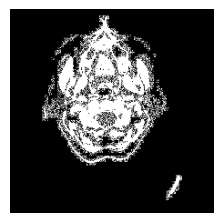

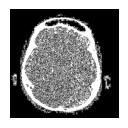

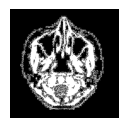

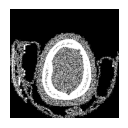

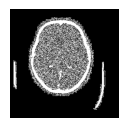

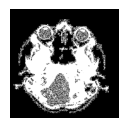

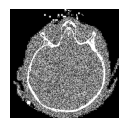

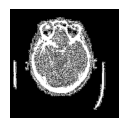

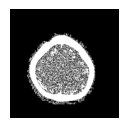

In [ ]:
rows= 3
cols= 3
for images, labels in data_ds.take(1):
    plt.figure(figsize=(cols*3, rows*3))
    for i in range(rows*cols):
            ax = plt.subplot(rows, cols, i+1)
            plt.imshow(tf.cast(images[i]*255, tf.uint8))
            plt.axis('off')
            plt.show()
    break

In [9]:
files_path = sorted(glob.glob('/content/files/**/*.jpg', recursive=True))
data = []
labels = []

for file_path in tqdm(files_path):

    file_name  = file_path.split('/')[3]
    class_name = file_path.split('.')[0]

    labels.append(class_name)



print(len(labels))


unique_labels = sorted(set(labels))
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
print("Label Mapping:", label_to_index)

labels_encoded = [label_to_index[l] for l in labels]


path_ds = tf.data.Dataset.from_tensor_slices((files_path, labels_encoded))


tumor


In [ ]:
def load_and_preprocess_image(path, label):
    img = tf.io.read_file(path)
    img = tf.io.decode_image(img, channels=3)
    img = tf.image.resize(img, [224, 224])
    img = tf.cast(img, tf.float32) / 255.0
    label = tf.one_hot(label, depth=len(unique_labels))
    return img, label


dataset = path_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
# dataset = dataset.cache()
dataset = dataset.shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
def build_file_list(root_dir):
    classes = sorted(os.listdir(root_dir))
    file_paths = []
    labels = []
    for idx, cls in enumerate(classes):
        cls_dir = os.path.join(root_dir, cls)
        for fp in glob.glob(os.path.join(cls_dir, '*')):
            file_paths.append(fp)
            labels.append(idx)
    return np.array(file_paths), np.array(labels), classes


def create_splits_with_stratification(root_dir, test_size=0.2, val_size=0.1, random_state=42):
    file_paths, labels, classes = build_file_list(root_dir)
    # First split into train+val and test
    X_temp, X_test, y_temp, y_test = train_test_split(file_paths, labels, test_size=test_size, stratify=labels, random_state=random_state)
    # Then split temp into train and val
    val_relative = val_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=val_relative, stratify=y_temp, random_state=random_state)
    return (X_train, y_train), (X_val, y_val), (X_test, y_test), classes



In [ ]:
train_ds, test_ds  = tf.keras.preprocessing.image_dataset_from_directory(image_dir,
                                                                         labels='inferred',
                                                                         label_mode='categorical',
                                                                         batch_size=32,
                                                                         image_size=(224,224),
                                                                         shuffle=True,
                                                                         seed=123,
                                                                         validation_split= 0.2,
                                                                         subset = 'both')

Found 259 files belonging to 3 classes.
Using 208 files for training.
Using 51 files for validation.


In [ ]:
def traditional_augmentation():
    return tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.05),
        tf.keras.layers.RandomTranslation(0.05, 0.05),
        tf.keras.layers.RandomZoom(0.1),
        tf.keras.layers.RandomContrast(0.1),
    ], name="data_augmentation")

# Add augmentation into pipeline (applied to batches)
data_augment = traditional_augmentation()
# usage inside model or dataset mapping:
# augmented_images = data_augment(images, training=True)


In [ ]:
def create_pretrained_baseline(model_name='resnet50', input_shape=(224,224,3), n_classes=2, base_trainable=False):
    """
    model_name: 'resnet50', 'efficientnetb0', 'mobilenetv2'
    """
    model_name == 'resnet50':
    base = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3)) # ResNet50 always expects 224x224
    preprocess = tf.keras.applications.resnet.preprocess_input

    base.trainable = base_trainable

    inputs = tf.keras.layers.Input(shape=input_shape)
    x = inputs # Assign inputs to x
    x = data_augment(x) # Apply data augmentation if needed
    # x = tf.keras.layers.Resizing(224, 224)(x) # Resize before passing to the base model
    x = base(x, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x_skip = x
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    outputs = tf.keras.layers.Dense(n_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',], callbacks= [ckpt_cb])
    return model


model_resnet = create_pretrained_baseline('resnet50', input_shape=(224,224,3), n_classes=3, base_trainable=False)
model_resnet.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,371 (90.98 MB)

 Trainable params: 262,659 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:

history = model_resnet.fit(train_ds, epochs=100,
                    validation_data=test_ds)

# Evaluate
test_loss, test_acc = model_resnet.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.2f}")


Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.5566 - loss: 1.0161 - val_accuracy: 0.9412 - val_loss: 0.1574
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.9096 - loss: 0.2039 - val_accuracy: 0.9020 - val_loss: 0.1848
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.9759 - loss: 0.0887 - val_accuracy: 0.9804 - val_loss: 0.0475
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - accuracy: 0.9807 - loss: 0.0525 - val_accuracy: 0.9804 - val_loss: 0.0386
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.9938 - loss: 0.0341 - val_accuracy: 0.9804 - val_loss: 0.0477
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.9939 - loss: 0.0223 - val_accuracy: 0.9804 - val_loss: 0.0326
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - accuracy: 0.9951 - loss: 0.0166 - val_accuracy: 0.9804 - val_loss: 0.0205
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - accuracy: 0.9913 - loss: 0.0213 - val_accuracy: 0.9804 - val

In [ ]:
from sklearn.model_selection import KFold

n_splits = 5  # Choose your desired number of folds
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

fold_accuracies = []

for fold_idx, (train_index, val_index) in enumerate(kf.split(train_images, train_labels)):
        print(f"Fold {fold_idx+1}/{n_splits}")
        X_train, X_val = train_images[train_index], train_images[val_index]
        y_train, y_val = train_labels[train_index], train_labels[val_index]

        model = create_pretrained_baseline('resnet50', input_shape=(32,32,3), n_classes=10, base_trainable=False)# Create a fresh model for each fold

        model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0) # Train the model

        _, accuracy = model.evaluate(X_val, y_val, verbose=0) # Evaluate on validation set
        fold_accuracies.append(accuracy)

print(f"Average accuracy across {n_splits} folds: {sum(fold_accuracies) / n_splits}")

In [ ]:
def implement_kfold_cross_validation(images, labels, n_splits=5, model_factory=create_pretrained_baseline, **model_kwargs):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold = 0
    histories = []
    metrics = []
    for train_idx, val_idx in skf.split(images, labels):
        fold += 1
        print(f"\n=== Fold {fold} ===")
        X_train, y_train = images[train_idx], labels[train_idx]
        X_val, y_val = images[val_idx], labels[val_idx]
        # Build tf.data datasets
        train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
        val_ds   = tf.data.Dataset.from_tensor_slices((X_val, y_val))

        train_ds.batch(32).prefetch(AUTOTUNE)
        val_ds.batch(32).prefetch(AUTOTUNE)
        # Create model
        model = model_factory(**model_kwargs)
        # Fit
        history = model.fit(train_ds, validation_data=val_ds, epochs=5)
        histories.append(history)
        eval_res = model.evaluate(val_ds)
        metrics.append(eval_res)
    return histories, metrics



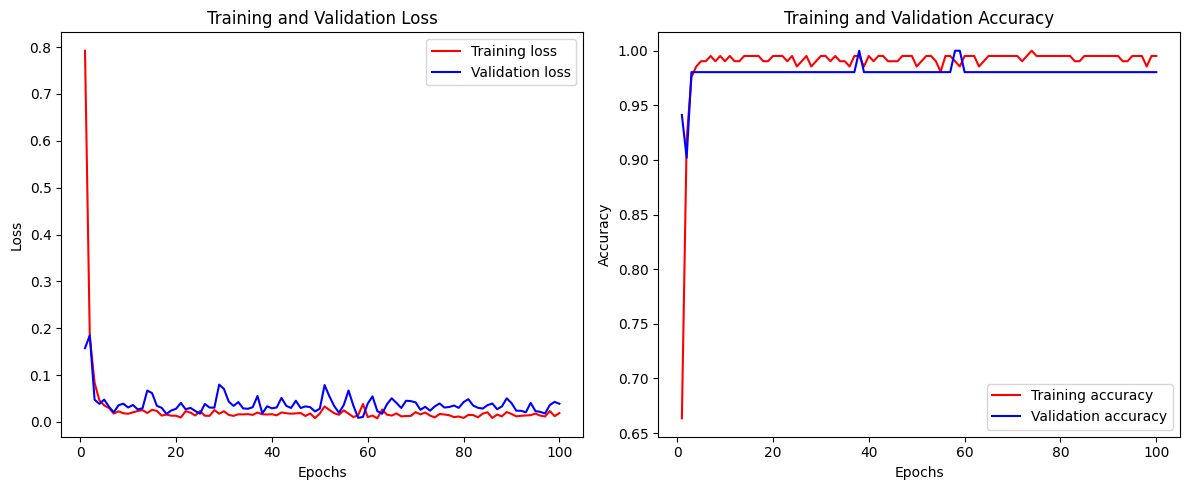

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step
Classification Report:

              precision    recall  f1-score   support

    Aneurysm       0.94      1.00      0.97        15
      Cancer       1.00      0.95      0.98        22
       Tumor       1.00      1.00      1.00        14

    accuracy                           0.98        51
   macro avg       0.98      0.98      0.98        51
weighted avg       0.98      0.98      0.98        51



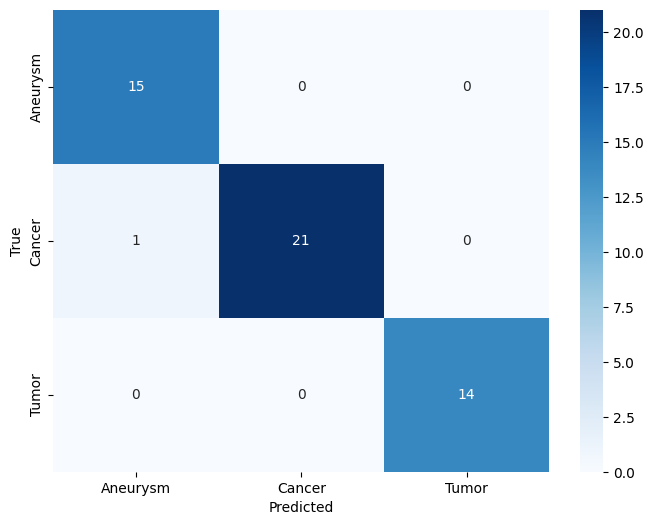

In [ ]:
def evaluate_and_report(model, dataset, class_names):
    # Collect predictions and true labels
    y_true = []
    y_pred = []
    all_images = []
    all_labels = []

    # Iterate through the dataset to collect images and labels
    for images, labels in dataset:
        all_images.append(images.numpy())
        all_labels.append(labels.numpy())

    # Concatenate the collected batches into numpy arrays
    all_images = np.concatenate(all_images, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)


    preds = model.predict(all_images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(all_labels, axis=1))

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)


    print("Classification Report:\n")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


evaluate_and_report(model_resnet, test_ds, ['Aneurysm','Cancer','Tumor'])

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


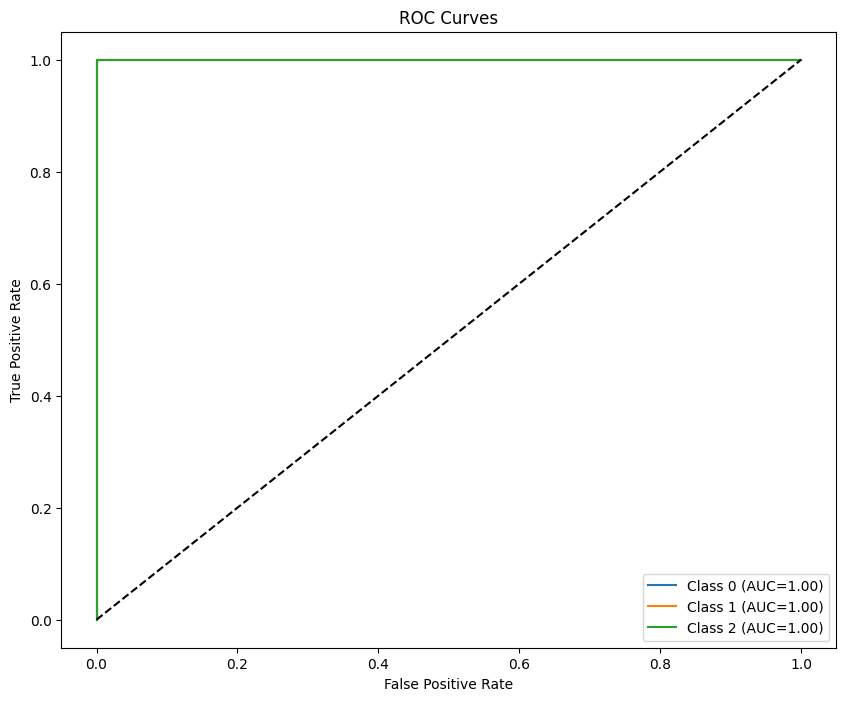

In [ ]:
def multiclass_roc_auc(model, dataset, n_classes):
    # Collect true one-hot and predicted probabilities
    y_true = []
    y_score = []
    for images, labels in dataset:
        preds = model.predict(images)
        y_score.append(preds)
        y_true.append(labels.numpy())
    y_true = np.vstack(y_true)
    y_score = np.vstack(y_score)
    # For each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    plt.figure(figsize=(10,8))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC={roc_auc[i]:.2f})")
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend()
    plt.show()

multiclass_roc_auc(model_resnet, test_ds, 3)

In [ ]:
ckpt_cb = tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')
es_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
for layer in model_resnet.get_layer('resnet50').layers:
    if isinstance(layer, tf.keras.layers.Conv2D):
        print(layer.name)

input_layer
conv1_pad
conv1_conv
conv1_bn
conv1_relu
pool1_pad
pool1_pool
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_conv
conv2_block1_2_bn
conv2_block1_2_relu
conv2_block1_0_conv
conv2_block1_3_conv
conv2_block1_0_bn
conv2_block1_3_bn
conv2_block1_add
conv2_block1_out
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_conv
conv2_block2_2_bn
conv2_block2_2_relu
conv2_block2_3_conv
conv2_block2_3_bn
conv2_block2_add
conv2_block2_out
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_conv
conv2_block3_2_bn
conv2_block3_2_relu
conv2_block3_3_conv
conv2_block3_3_bn
conv2_block3_add
conv2_block3_out
conv3_block1_1_conv
conv3_block1_1_bn
conv3_block1_1_relu
conv3_block1_2_conv
conv3_block1_2_bn
conv3_block1_2_relu
conv3_block1_0_conv
conv3_block1_3_conv
conv3_block1_0_bn
conv3_block1_3_bn
conv3_block1_add
conv3_block1_out
conv3_block2_1_conv
conv3_block2_1_bn
conv3_block2_1_relu
conv3_block2_2_conv
conv3_block2_2_bn
co

In [ ]:
model_resnet.get_layer('resnet50').get_layer('conv5_block3_out')

<Activation name=conv5_block3_out, built=True>